#  Pima Indians Diabetes K-Nearest Neighbors Classification

- Name: Christopher White
- Date: 9/16/2018
- Programming Language: Python
- Primary References:
    - https://www.kaggle.com/ash316/ml-from-scratch-part-2
    - https://www.kaggle.com/ash316/ml-from-scratch-with-iris
    - https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/
    - http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html
    - https://www.kaggle.com/paulbrabban/intro-to-feature-selection
    - https://chrisalbon.com/python/data_visualization/matplotlib_grouped_bar_plot/
    - http://lovefordatascience.blogspot.com/2017/10/data-analysis-and-visualization-in.html
    - https://towardsdatascience.com/machine-learning-workflow-on-diabetes-data-part-01-573864fcc6b8
    - http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
    - https://stats.stackexchange.com/questions/219655/k-nn-computational-complexity

In [3]:
# data transformation modules:
import pandas as pd
import numpy as np

# machine learning modules:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import metrics 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix 

# visualiation modules:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns

%matplotlib inline

# seed the generator to keep results consistent between runs
np.random.seed(1001)


In [4]:
import time
import psutil
import os

# def init_timer():
# Initalize timer table
columns = ["Section" ,"Start" ,"Stop" ,"Elapsed" ,"Elapsed_Sec" ,"Elapsed_Min" 
           ,"Elapsed_Hour" ,"Memory_Start" ,"Memory_End" ,"Memory_Delta"]

timer_table = pd.DataFrame(columns=columns)
timer_table.reset_index()

# initialize indexing
i = -1

def timer_start(timer_table, i, section_name = "Default"):
    start_millis = int(round(time.time() * 1000))
#     increment the index
    i = i + 1
    timer_table.loc[i,"Section"] = section_name
    timer_table.loc[i,"Start"] = start_millis
    
    #Memory Stats
    process = psutil.Process(os.getpid())
    timer_table.loc[i,"Memory_Start"] = process.memory_info().rss
    
    return timer_table, i

def timer_end(timer_table, section_name = "Default"):
    start_millis = int(round(time.time() * 1000))
    timer_table.loc[i,"Stop"] = start_millis
    timer_table["Elapsed"] = timer_table["Stop"] - timer_table["Start"]
    timer_table["Elapsed_Sec"] = timer_table["Elapsed"]/1000
    timer_table["Elapsed_Min"] = timer_table["Elapsed_Sec"]/60
    timer_table["Elapsed_Hour"] = timer_table["Elapsed_Min"]/60

    #Memory Stats
    process = psutil.Process(os.getpid())
    timer_table.loc[i,"Memory_End"] = process.memory_info().rss
    timer_table["Memory_Delta"] = timer_table["Memory_End"] - timer_table["Memory_Start"]
    
    return timer_table    


# Dataset Details

In [5]:
# Data Dictionary:

# Features:
    # Pregnancies - Number of times pregnant
    # Glucose - Plasma glucose concentration a 2 hours in an oral glucose tolerance test
    # Blood - PressureDiastolic blood pressure (mm Hg)
    # Skin - ThicknessTriceps skin fold thickness (mm)
    # Insulin - 2-Hour serum insulin (mu U/ml)
    # BMI - Body mass index (weight in kg/(height in m)^2)
    # DiabetesPedigreeFunction - Diabetes pedigree function
    # Age - Age (years)

# Label:
    # Outcome - Class variable (0 or 1) 0=no diabetes; 1=diabetes

In [6]:
# read in data
df = pd.read_csv('./Input/diabetes.csv')

df.head(3) # print the first 3 samples

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


# Exploratory Data Analysis

In [7]:
df.dtypes # view the data types

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [8]:
#check for missing variables
na_vals = df.isnull().sum()
print(na_vals)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [9]:
#scaling required due to data not being scaled uniformly
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


Number of Positive:  268
Number of Negative :  500


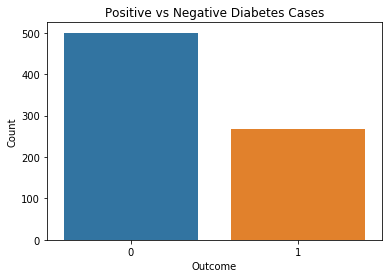

In [11]:
ax = sns.countplot(x = 'Outcome', data=df);      # pos = 268, neg = 500
ax.set_title('Positive vs Negative Diabetes Cases')
ax.set_ylabel('Count')
handles, labels = ax.get_legend_handles_labels()

pos = df.loc[df['Outcome'] == 1,'Outcome'].count()
neg = df.loc[df['Outcome'] != 1,'Outcome'].count()

print('Number of Positive: ', pos)
print('Number of Negative : ', neg)

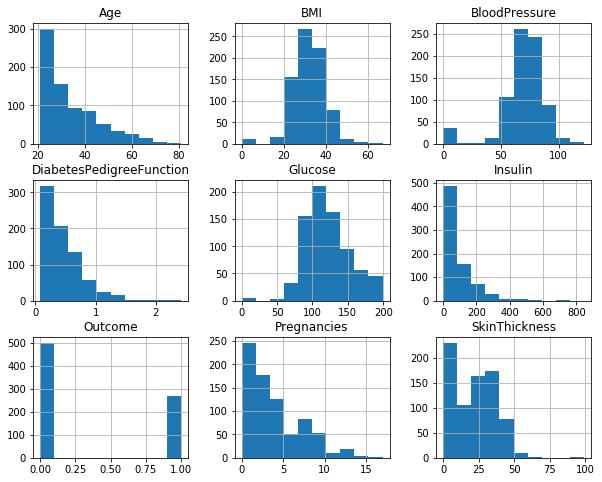

In [12]:
# Explore distrribution of values for each feature 
df.hist(figsize=(10,8));

In [13]:
# count zero values
print("Age Zero Value Count: " + str(df[df['Age'] == 0].shape[0]))
print("BMI Value Count: " + str(df[df['BMI'] == 0].shape[0]))
print("Blood Pressure Zero Value Count: " + str(df[df['BloodPressure'] == 0].shape[0]))

print("Diabetes Pedigree Function Zero Value Count: " + str(df[df['DiabetesPedigreeFunction'] == 0].shape[0]))
print("Glucose Zero Value Count: " + str(df[df['Glucose'] == 0].shape[0]))
print("Insulin Zero Value Count: " + str(df[df['Insulin'] == 0].shape[0]))

print("Pregnancies Zero Value Count: " + str(df[df['Pregnancies'] == 0].shape[0]))
print("Skin Thickness Zero Value Count: " + str(df[df['SkinThickness'] == 0].shape[0]))


Age Zero Value Count: 0
BMI Value Count: 11
Blood Pressure Zero Value Count: 35
Diabetes Pedigree Function Zero Value Count: 0
Glucose Zero Value Count: 5
Insulin Zero Value Count: 374
Pregnancies Zero Value Count: 111
Skin Thickness Zero Value Count: 227


In [14]:
#simplelest way to deal with this data would be through mean or median imputation
#median is not influenced by outliers like mean
BMI_mean = df['BMI'].mean(skipna=True)
df['BMI']=df.BMI.mask(df.BMI == 0,BMI_mean)

BloodPressure_mean = df['BloodPressure'].mean(skipna=True)
df['BloodPressure']=df.BloodPressure.mask(df.BloodPressure == 0,BloodPressure_mean)

Glucose_mean = df['Glucose'].mean(skipna=True)
df['Glucose']=df.Glucose.mask(df.Glucose == 0,Glucose_mean)

Insulin_mean = df['Insulin'].mean(skipna=True)
df['Insulin']=df.Insulin.mask(df.Insulin == 0,Insulin_mean)

SkinThickness_mean = df['SkinThickness'].mean(skipna=True)
df['SkinThickness']=df.SkinThickness.mask(df.SkinThickness == 0,SkinThickness_mean)

print("Zero Value Count after Median Imputation")
print("----------------------------------------")
print("Age Zero Value Count: " + str(df[df['Age'] == 0].shape[0]))
print("BMI Value Count: " + str(df[df['BMI'] == 0].shape[0]))
print("Blood Pressure Zero Value Count: " + str(df[df['BloodPressure'] == 0].shape[0]))

print("Diabetes Pedigree Function Zero Value Count: " + str(df[df['DiabetesPedigreeFunction'] == 0].shape[0]))
print("Glucose Zero Value Count: " + str(df[df['Glucose'] == 0].shape[0]))
print("Insulin Zero Value Count: " + str(df[df['Insulin'] == 0].shape[0]))

print("Pregnancies Zero Value Count: " + str(df[df['Pregnancies'] == 0].shape[0]))
print("Skin Thickness Zero Value Count: " + str(df[df['SkinThickness'] == 0].shape[0]))


Zero Value Count after Median Imputation
----------------------------------------
Age Zero Value Count: 0
BMI Value Count: 0
Blood Pressure Zero Value Count: 0
Diabetes Pedigree Function Zero Value Count: 0
Glucose Zero Value Count: 0
Insulin Zero Value Count: 0
Pregnancies Zero Value Count: 111
Skin Thickness Zero Value Count: 0


/Users/chriswhite/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/chriswhite/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/chriswhite/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/chriswhite/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype

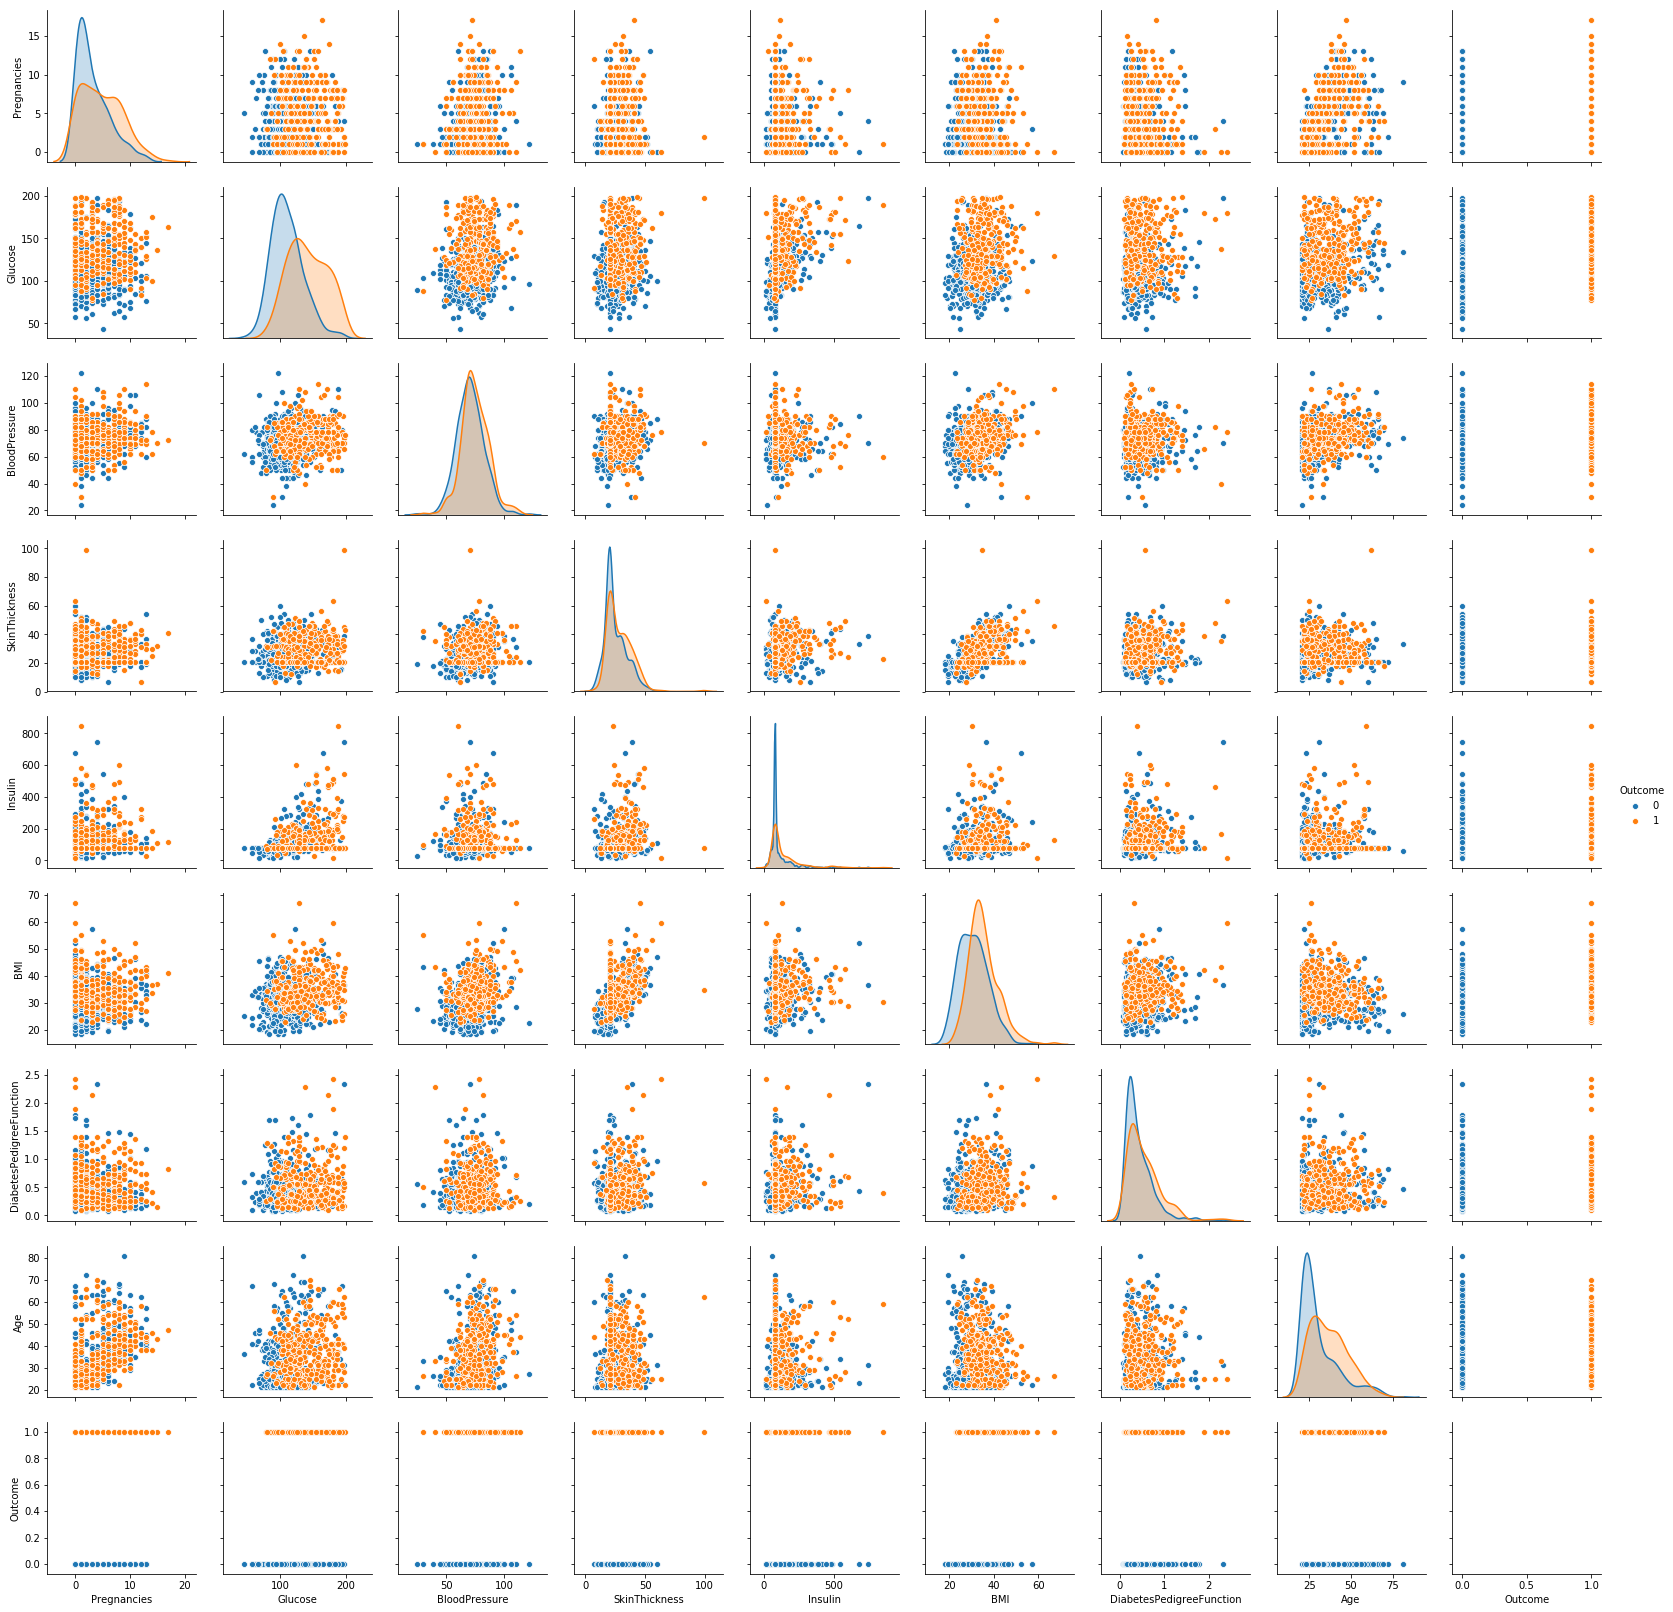

In [16]:
#create a pairplot to visualize the relationships between all features
sns.pairplot(data=df, hue='Outcome', diag_kind='kde');
plt.show()

In [17]:
def box_plot(df, cols,title):
    data = np.array(df.values.tolist())
    plt.boxplot(data, labels=cols, showmeans=True)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()

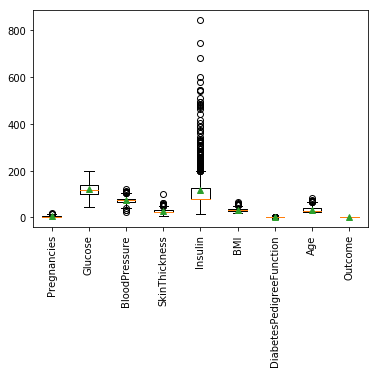

In [18]:
#unscaled data boxplot
box_plot(df,df.columns,"")

In [19]:
#create X and y dataframes:
feature1 = "Pregnancies"
feature2 = "Glucose"
feature3 = "BloodPressure"
feature4 = "SkinThickness"
feature5 = "Insulin"
feature6 = "BMI"
feature7 = "DiabetesPedigreeFunction"
feature8 = "Age"

label = "Outcome"

feature_data = df[[feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8]]

label_data = df.loc[:, [label]] #retain a single column pandas dataframe


In [20]:
#scale the data
scaler = StandardScaler()
#on continuous predictors
scaler.fit(feature_data)
feature_data_scaled = pd.DataFrame(scaler.transform(feature_data), columns = feature_data.columns) #columns, brings the column names back
feature_data_scaled.head()
#values have now been replaced with the average distance from the mean.

/Users/chriswhite/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/chriswhite/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.865276,-0.021044,0.872057,-0.417768,0.167255,0.468492,1.425995
1,-0.844885,-1.205989,-0.516583,0.248678,-0.417768,-0.851535,-0.365061,-0.190672
2,1.233880,2.015979,-0.681762,-0.630654,-0.417768,-1.331821,0.604397,-0.105584
3,-0.844885,-1.074480,-0.516583,-0.374700,-0.265107,-0.633222,-0.920763,-1.041549
4,-1.141852,0.503626,-2.663916,0.872057,0.530423,1.549899,5.484909,-0.020496


/Users/chriswhite/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/chriswhite/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/chriswhite/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/chriswhite/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype

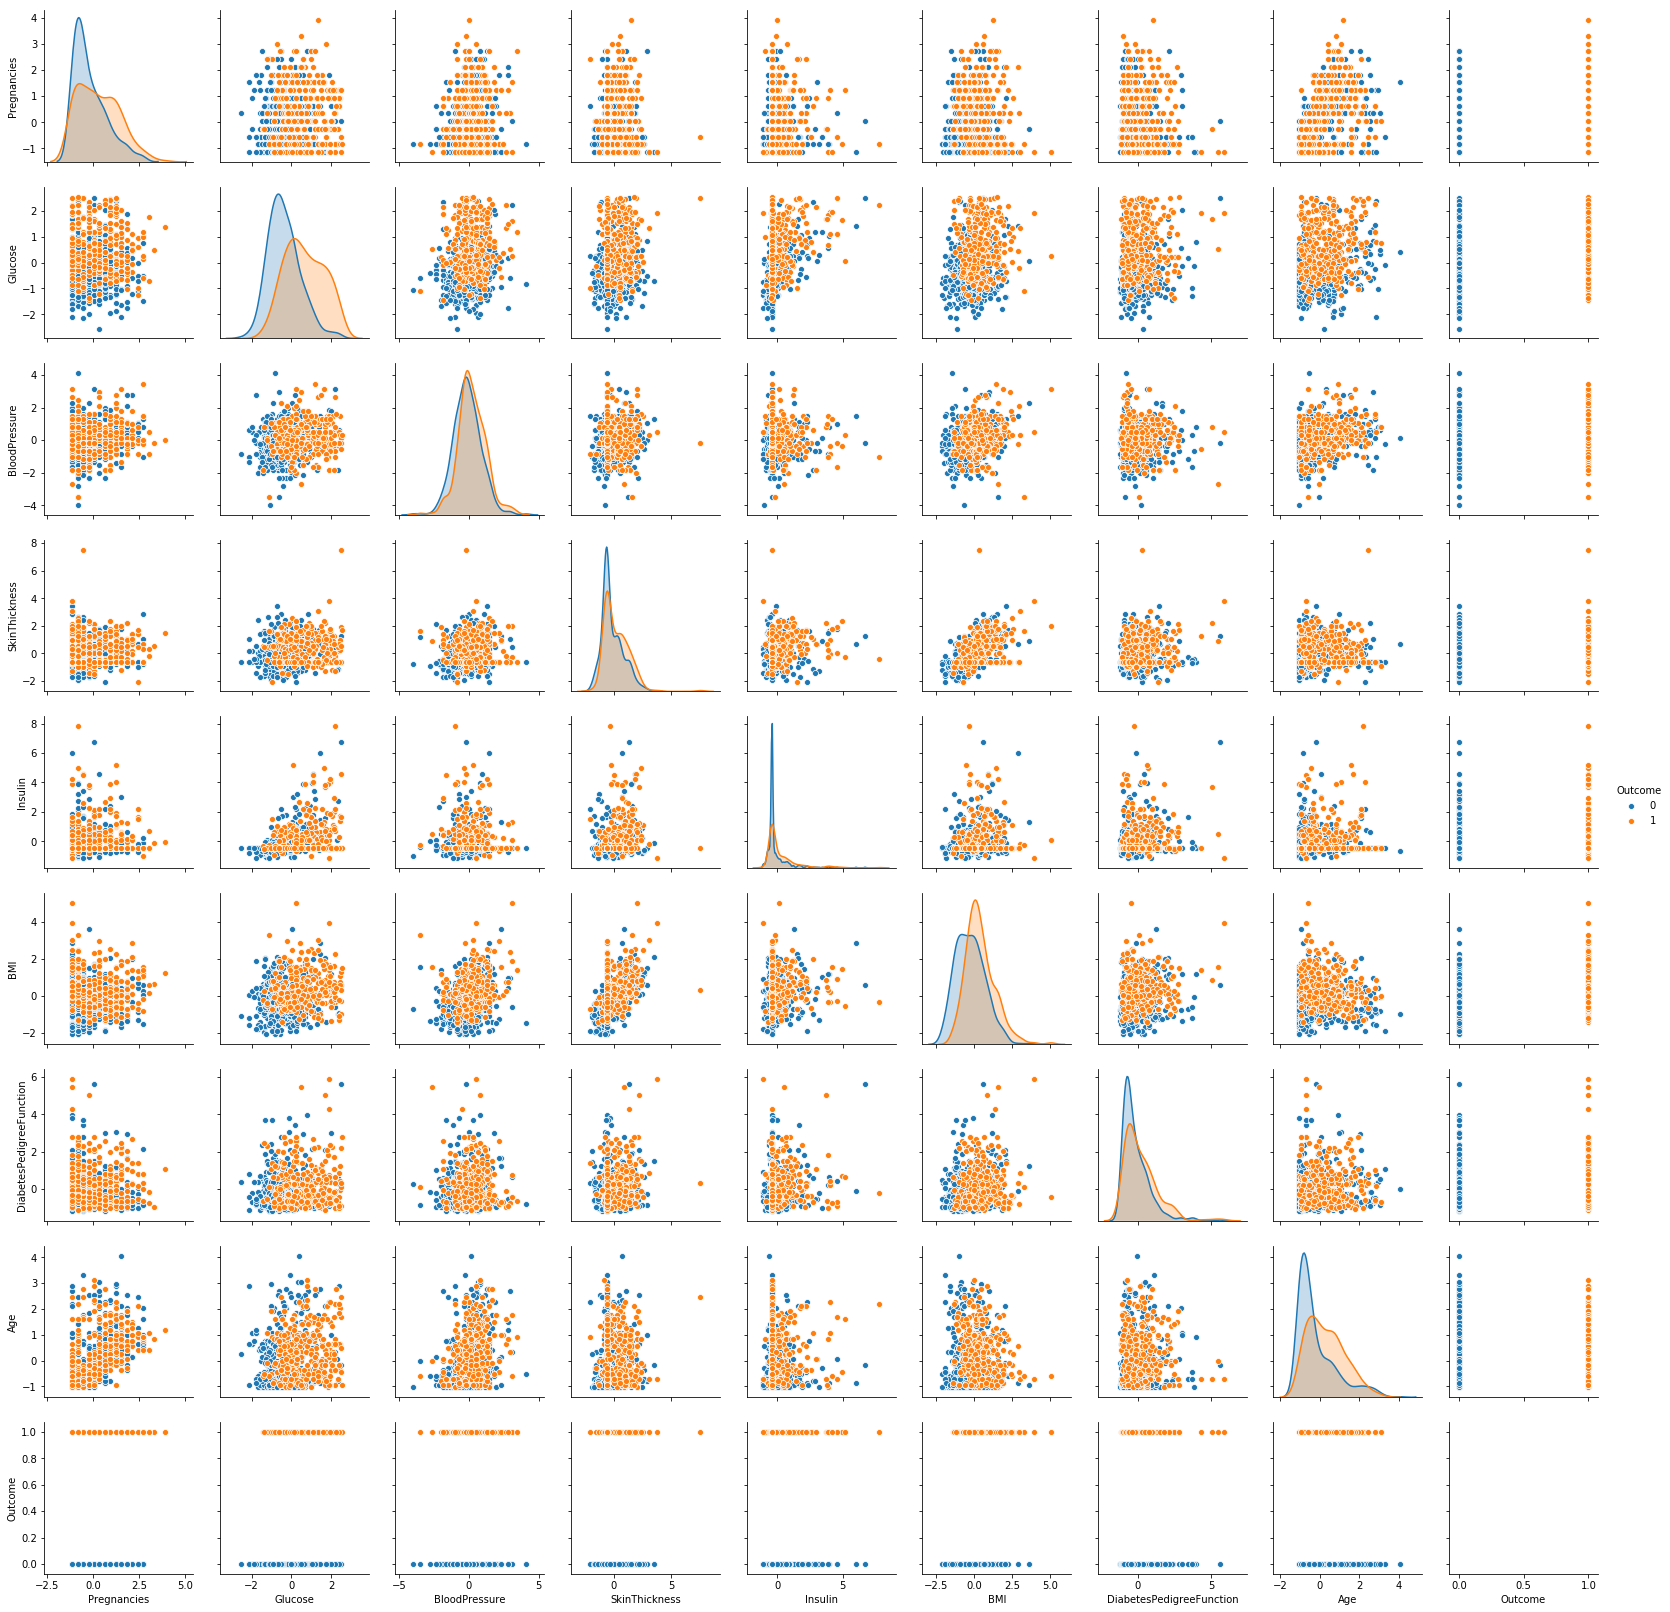

In [21]:
# merge the scaled feature data onto the y labels
df_scaled = pd.merge(feature_data_scaled, label_data, left_index=True, right_index=True)

sns.pairplot(data=df_scaled,hue='Outcome',diag_kind='kde');
plt.show()

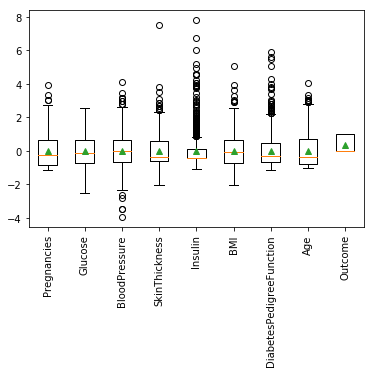

In [22]:
#visualize the Scaled Feature Box Plot
box_plot(df_scaled,df_scaled.columns,"")

# Static Train, Validation and Test datasets

In [23]:
# Split data into train, validation, and test sets
X, X_test, y, y_test = train_test_split(feature_data_scaled, label_data, test_size = 0.1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = len(X_test)/len(X))
print(X.shape)
print("X_test shape: " + str(X_test.shape))
print('-----------')
print("X_train shape: " + str(X_train.shape))
print("X_val shape: " + str(X_val.shape))


(691, 8)
X_test shape: (77, 8)
-----------
X_train shape: (614, 8)
X_val shape: (77, 8)


In [24]:
def KNN_model(X_train,X_val,y_train,y_val,n_num):
    knn_model = KNeighborsClassifier(n_neighbors=n_num, metric='euclidean')
    knn_model.fit(X_train,y_train.values.ravel())

    prediction = knn_model.predict(X_val)

    print('The accuracy of the KNN is:',metrics.accuracy_score(prediction,y_val))
    return prediction, knn_model


In [25]:
#KNN
all_features = [feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8]
X_train = X_train[all_features]
X_val = X_val[all_features]
X_test = X_test[all_features]

X_train.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
50,-0.844885,-0.614199,0.639674,-1.621458,-0.394112,-1.899433,0.057756,-0.956462
706,1.827813,-0.219673,-0.260103,-0.630654,-0.417768,-0.066691,-0.636871,-0.275760
98,0.639947,-0.942972,-1.838019,0.352575,-0.587619,-0.545898,-0.349960,-0.871374
624,-0.547919,-0.449813,-0.681762,-0.630654,-0.417768,-0.240261,-0.947944,-1.041549
584,1.233880,0.076222,0.309315,-0.270804,5.174599,-0.545898,0.649699,1.596171


In [26]:
section_name_2 = "KNN_Training_Time"
timer_table, i = timer_start(timer_table
                             ,i
                             ,section_name = section_name_2)

prediction, knn_model = KNN_model(X_train,X_val,y_train,y_val,3)

timer_table = timer_end(timer_table
                        ,section_name = section_name_2)



The accuracy of the KNN is: 0.7142857142857143


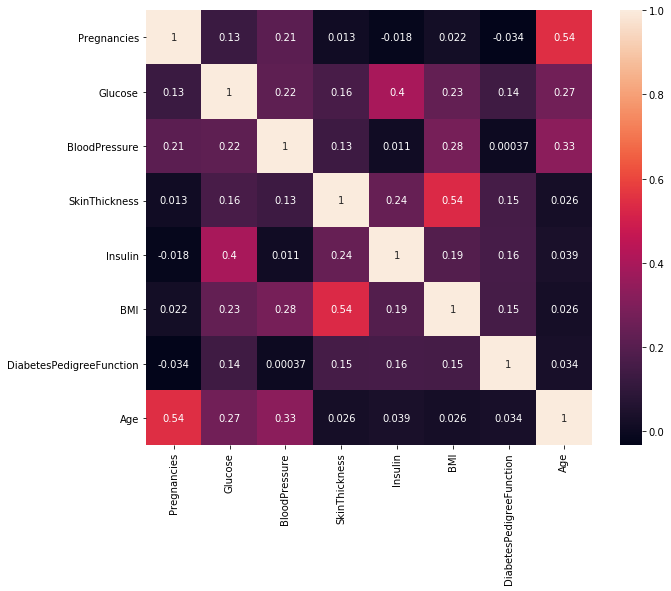

In [27]:
sns.heatmap(feature_data_scaled.corr(),annot=True)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [28]:
def KNN_model_multi_k(X_train,X_val,y_train,y_val):
    
    a_index=list(range(1,11))
    a=pd.Series()

    for i in list(range(1,11)):
        print("modeling with k =" + str(i))
        model = KNeighborsClassifier(n_neighbors = i,metric='euclidean')
        model.fit(X_train,y_train.values.ravel())
        prediction = model.predict(X_val)
        a = a.append(pd.Series(metrics.accuracy_score(prediction,y_val)))
    plt.plot(a_index, a)
    plt.title("KNN Classification")
    plt.xlabel("K")
    plt.ylabel("Accuracy")
    plt.xticks(a_index);


modeling with k =1
modeling with k =2
modeling with k =3
modeling with k =4
modeling with k =5
modeling with k =6
modeling with k =7
modeling with k =8
modeling with k =9
modeling with k =10


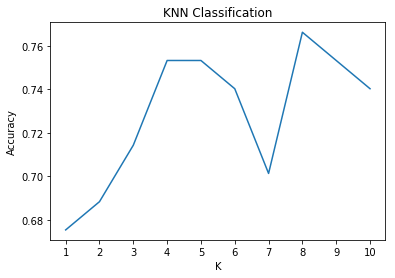

In [31]:
section_name_2 = "KNN_Validation_Time"
timer_table, i = timer_start(timer_table, i, section_name = section_name_2)

KNN_model_multi_k(X_train, X_val, y_train, y_val)

timer_table = timer_end(timer_table, section_name = section_name_2)


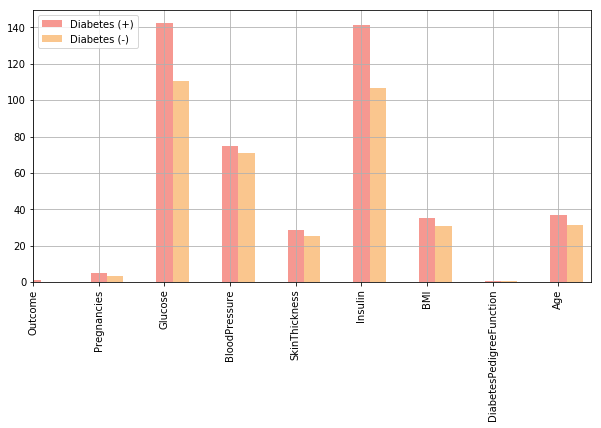

In [32]:
def bar_plot(df):

    df_neg = df[df['Outcome'] == 0]
    df_pos = df[df['Outcome'] == 1] 

    # determine the mean results for all features by outcome
    mean_neg = df_neg.groupby(['Outcome'], as_index=False).mean()
    mean_pos = df_pos.groupby(['Outcome'], as_index=False).mean()

    # transpose dataframes
    mean_pos_tr = mean_pos.T
    mean_neg_tr = mean_neg.T

    # mean_pos_tr
    # mean_neg_tr

    # merge positive and negative cancer mean results and rename columns
    df_mean = pd.merge(mean_pos_tr, mean_neg_tr, left_index=True, right_index=True)
    df_mean.reset_index(level=0, inplace=True)
    df_mean_new = df_mean.rename(index=str, columns={"index": "features", "0_x": "mean_pos", "0_y": "mean_neg"})
    # df_mean_new

    # Setting the positions and width for the bars
    pos = list(range(len(df_mean_new['features']))) 
    width = 0.25 

    # Plotting the bars
    fig, ax = plt.subplots(figsize=(10,5))

    # Create a bar with mean_pos data,
    # in position pos,
    plt.bar(pos, 
        df_mean_new['mean_pos'], #using df['mean_pos'] data,
        width, # of width
        alpha=0.5, # with alpha 0.5
        color='#EE3224', # with color
        label=df_mean_new['features'][0] # with label the first value in first_name
       ) 

    # Create a bar with mean_neg data,
    # in position pos + some width buffer,
    plt.bar([p + width for p in pos], 
        df_mean_new['mean_neg'], #using df['mid_score'] data,
        width, # of width
        alpha=0.5, # with alpha 0.5
        color='#F78F1E', # with color
        label=df_mean_new['features'][1] # with label the second value in first_name
       ) 

    # configure the labels for the x ticks
    ax.set_xticklabels(df_mean_new['features'],rotation='vertical')

    # configure the x-axis limits
    plt.xlim(0, max(pos)+width*2)

    # add a legend and display the plot the plot
    plt.legend(['Diabetes (+)', 'Diabetes (-)'], loc='upper left')
    plt.grid()
    return plt, df_mean_new
    
plt, df_mean_new = bar_plot(df)
plt.show()

In [34]:
# find the features with the greatest difference between the diabetes and non diabetes pops
df4 = df_mean_new[['features','mean_pos','mean_neg']]
df4['percent_diff_1'] = abs((df4['mean_pos'] - df4['mean_neg']))
df4['percent_diff_2'] = ((df4['mean_pos'] + df4['mean_neg']))/2
df4['percent_diff_final'] = abs(df4['percent_diff_1']/df4['percent_diff_2']) * 100
df4_final = df4.sort_values(by ='percent_diff_final',ascending=False)
df4_final

,features,mean_pos,mean_neg,percent_diff_1,percent_diff_2,percent_diff_final
0,Outcome,1.000000,0.000000,1.000000,0.500000,200.000000
1,Pregnancies,4.865672,3.298000,1.567672,4.081836,38.406044
5,Insulin,141.426597,106.457354,34.969243,123.941976,28.214205
2,Glucose,142.159661,110.705367,31.454293,126.432514,24.878326
7,DiabetesPedigreeFunction,0.550500,0.429734,0.120766,0.490117,24.640239
8,Age,37.067164,31.190000,5.877164,34.128582,17.220651
6,BMI,35.381288,30.880066,4.501221,33.130677,13.586265
4,SkinThickness,28.907494,25.373135,3.534358,27.140315,13.022540
3,BloodPressure,74.950326,70.810008,4.140319,72.880167,5.680995


In [35]:
# select the top 4 features with the greatest difference

# feature1 = "Pregnancies"
# feature2 = "Glucose"
# feature5 = "Insulin"
# feature7 = "DiabetesPedigreeFunction"

feature_subset = [feature1,feature2,feature5,feature7]

X_train_subset = X_train[feature_subset]
X_val_subset = X_val[feature_subset]
X_test_subset = X_test[feature_subset]

X_train_subset.head()

,Pregnancies,Glucose,Insulin,DiabetesPedigreeFunction
50,-0.844885,-0.614199,-0.394112,0.057756
706,1.827813,-0.219673,-0.417768,-0.636871
98,0.639947,-0.942972,-0.587619,-0.349960
624,-0.547919,-0.449813,-0.417768,-0.947944
584,1.233880,0.076222,5.174599,0.649699


modeling with k =1
modeling with k =2
modeling with k =3
modeling with k =4
modeling with k =5
modeling with k =6
modeling with k =7
modeling with k =8
modeling with k =9
modeling with k =10


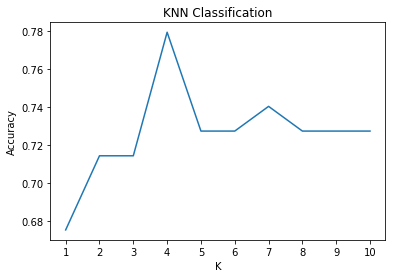

In [36]:
KNN_model_multi_k(X_train_subset,X_val_subset,y_train,y_val)

In [37]:
# run subset features at a k = 4
prediction, knn_model = KNN_model(X_train_subset,X_val_subset,y_train,y_val,8)


The accuracy of the KNN is: 0.7272727272727273


In [38]:
# confusion matrix , false positives/ false negatives for validation data ; totals 77 observations
conf = confusion_matrix(prediction, y_val)
df3 = pd.DataFrame(data=conf,columns=['0','1'])
# tn, fp, fn, tp = confusion_matrix(prediction, y_val).ravel()
# tn, fp, fn, tp

df3
#             predicted Cancerous
#                     no, yes
# actually      no    tn, fp
# cancerous     yes   fn, tp

,0,1
0,45,15
1,6,11


(691, 4)
(691, 1)
modeling with k =1
modeling with k =2
modeling with k =3
modeling with k =4
modeling with k =5
modeling with k =6
modeling with k =7
modeling with k =8
modeling with k =9
modeling with k =10


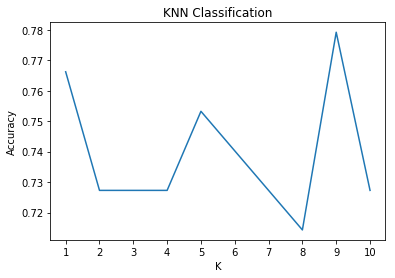

In [39]:
# run subset features at a k = 4 on test set
# maybe combine the train and validation sets?
# prediction_fin, knn_model = KNN_model(X_train_subset,X_test_subset,y_train,y_test,4)
X_train_val_subset = X_train_subset.append(X_val_subset)
y_train_val = y_train.append(y_val)
print(X_train_val_subset.shape) 
print(y_train_val.shape)
KNN_model_multi_k(X_train_subset,X_test_subset,y_train,y_test)
# KNN_model_multi_k(X_train_val_subset,X_test_subset,y_train_val,y_test)

In [40]:
# run subset features at a k = 9

section_name_2 = "KNN_Test_Model_and_Prediction_Time"
timer_table, i = timer_start(timer_table
                             ,i
                             ,section_name = section_name_2)

prediction_best_k, knn_model = KNN_model(X_train_subset,X_test_subset,y_train,y_test,9)

timer_table = timer_end(timer_table
                        ,section_name = section_name_2)


The accuracy of the KNN is: 0.7792207792207793


In [41]:
timer_table

,Section,Start,Stop,Elapsed,Elapsed_Sec,Elapsed_Min,Elapsed_Hour,Memory_Start,Memory_End,Memory_Delta
0,KNN_Training_Time,1546723205381,1546723205425,44,0.044,0.000733333,1.22222e-05,33918976,37793792,3874816
1,KNN_Validation_Time,1546723333826,1546723333950,124,0.124,0.00206667,3.44444e-05,27500544,40615936,13115392
2,KNN_Test_Model_and_Prediction_Time,1546723495599,1546723495606,7,0.007,0.000116667,1.94444e-06,53813248,54181888,368640


In [42]:
#confusion matrix on the testing dataset
conf_fin = confusion_matrix(prediction_best_k, y_test)
df4 = pd.DataFrame(data=conf_fin,columns=['0','1'])
# tn, fp, fn, tp = confusion_matrix(prediction, y_val).ravel()
# tn, fp, fn, tp

df4


#             predicted Diabetic
#                     no, yes
# actually      no    tn, fp
# Diabetic     yes   fn, tp





,0,1
0,45,11
1,6,15
